In [1]:
%matplotlib inline

import gc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp
import numpy as np
import theano.tensor as tt

plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**11.1. Ordered categorical outcomes**

In [3]:
data = pd.read_csv('../data/Trolley.csv', sep=';')
data.sample(5)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
4203,cibox,7,32,97;264,57,1,Master's Degree,0,1,1,box,1
911,fkspe,4,9,96;581,26,1,Bachelor's Degree,1,0,0,spe,1
3890,ikpon,1,32,97;194,37,0,Some College,1,1,0,pon,1
2432,cfrub,4,7,96;839,36,1,Master's Degree,0,0,1,rub,1
3731,fkspe,3,14,97;166,46,1,Bachelor's Degree,1,0,0,spe,1


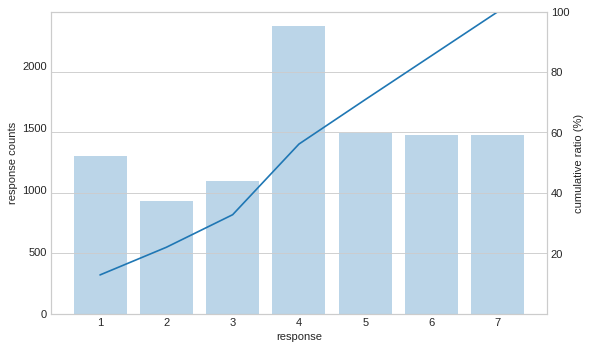

In [4]:
response_counts, responses = np.histogram(data.response, bins= np.linspace(1, 8, 8))
cum_freq = response_counts.cumsum() / response_counts.sum()

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.bar(responses[:-1], response_counts, alpha=.3)
ax.set(ylabel='response counts', xlabel='response')
ax.grid(None)

ax2 = ax.twinx()
ax2.plot(responses[:-1], cum_freq * 100)
ax2.set(ylabel='cumulative ratio (%)',
        ylim=(0, 100),
        yticks=np.linspace(0, 100, 6)[1:])
None

In [5]:
with pm.Model() as m11_1:
    cutpoints = pm.Normal(
        'cutpoints', mu=0, sd=1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.linspace(-3, 3, 6))

    responses = pm.OrderedLogistic(
        'responses', 0., cutpoints,
        observed=data.response - 1
    )

    m11_1.name = 'm11.1'
    m11_1.trace = pm.sample(3000, tune=1000, chains=2)


/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWar

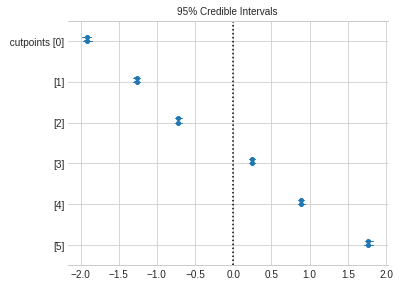

In [6]:
pm.forestplot(m11_1.trace, varnames=['cutpoints'], rhat=False)
None

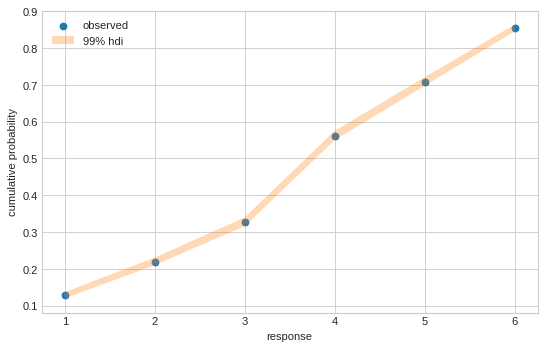

In [7]:
tmp = pd.DataFrame(m11_1.trace['cutpoints']).stack().map(sp.special.expit).reset_index()
tmp = tmp.groupby('level_1')[0].apply(summarize(0.01)).unstack()

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.scatter(tmp.index + 1, cum_freq[:-1], label='observed')
ax.fill_between(tmp.index+1, tmp.lower, tmp.upper, alpha=.3, label='99% hdi')

ax.set(xlabel='response', ylabel='cumulative probability')
ax.legend()
None

In [8]:
with pm.Model() as m11_2:
    cutpoints = pm.Normal(
        'cutpoints', 0., 1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.linspace(-3, 3, 6))

    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    
    phi = (
        beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m11_2.name = 'm11.2'
    m11_2.trace = pm.sample(3000, tune=1000, chains=2)


/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, cutpoints]
Sampling 2 chains: 100%|██████████| 8

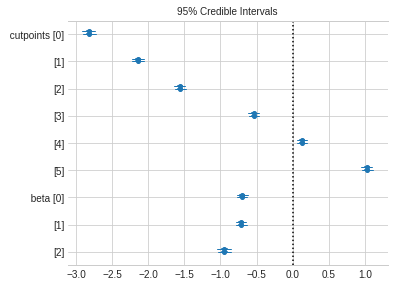

In [9]:
pm.forestplot(m11_2.trace, varnames=['cutpoints', 'beta'], rhat=False)
None

In [10]:
with pm.Model() as m11_3:
    cutpoints = pm.Normal(
        'cutpoints', 0., 1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.linspace(-3, 3, 6))

    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    beta2 = pm.Normal('beta2', mu=0, sd=0.5, shape=2)
    
    phi = (
        beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
        + beta2[0] * (data.intention.values * data.action.values)
        + beta2[1] * (data.intention.values * data.contact.values)
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m11_3.name = 'm11.3'
    start = pm.find_MAP()
    m11_3.trace = pm.sample(3000, tune=1000, chains=2, start=start)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = -18,470, ||grad|| = 5.7343: 100%|██████████| 28/28 [00:00<00:00, 174.12it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS 

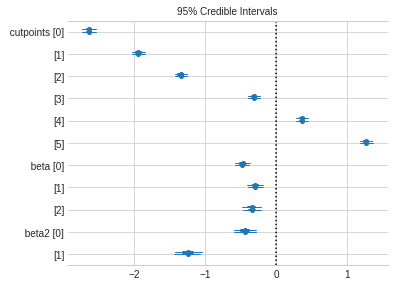

In [11]:
pm.forestplot(m11_3.trace, varnames=['cutpoints', 'beta', 'beta2'], rhat=False)
None

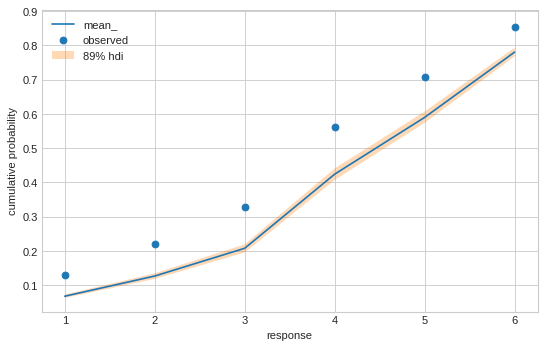

In [12]:
tmp = pd.DataFrame(m11_3.trace['cutpoints']).stack().map(sp.special.expit).reset_index()
tmp = tmp.groupby('level_1')[0].apply(summarize(0.11)).unstack()

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.scatter(tmp.index + 1, cum_freq[:-1], label='observed')
ax.plot(tmp.index + 1, tmp.mean_)
ax.fill_between(tmp.index+1, tmp.lower, tmp.upper, alpha=.3, label='89% hdi')

ax.set(xlabel='response', ylabel='cumulative probability')
ax.legend()
None

In [13]:
comparison = pm.compare({
        m11_1: m11_1.trace,
        m11_2: m11_2.trace,
        m11_3: m11_3.trace,
    },
    method='BB-pseudo-BMA'
)

comparison

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
m11.3,36929.2,10.96,0,1,83.04,0,0
m11.2,37090,9.02,160.83,0,77.54,25.01,0
m11.1,37854.4,5.99,925.23,0,59.14,61.98,0


---
**Ordered categorical predictors**

In [14]:
data.edu.unique()

edus = pd.DataFrame(list(enumerate([
    'Elementary School', 'Middle School','Some High School', 
    'High School Graduate', 'Some College', "Bachelor's Degree", 
    "Master's Degree", 'Graduate Degree'])),
    columns=['edu_i', 'edu'])

data = pd.merge(
    data, edus, on='edu'
)

In [15]:
data.sample(5)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,edu_i
806,ilsha,4,21,96;741,56,0,Bachelor's Degree,0,1,0,sha,0,5
8950,fkcar,5,6,97;418,25,0,Graduate Degree,1,0,0,car,1,7
7029,fkbur,5,22,97;439,32,1,Master's Degree,1,0,0,bur,1,6
130,fkcar,1,6,96;445,53,1,Bachelor's Degree,1,0,0,car,1,5
1392,fkswi,1,25,97;113,41,1,Bachelor's Degree,1,0,0,swi,1,5


In [16]:
edus

,edu_i,edu
0,0,Elementary School
1,1,Middle School
2,2,Some High School
3,3,High School Graduate
4,4,Some College
5,5,Bachelor's Degree
6,6,Master's Degree
7,7,Graduate Degree


In [17]:
with pm.Model() as m_ord_cat:
    n_edus = edus.shape[0]

    cutpoints = pm.Normal(
        'cutpoints', mu=0, sd=1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.linspace(-3, 3, 6),
    )
    beta_edu = pm.Normal('beta_edu', mu=0, sd=0.5)
    delta_edu = pm.Dirichlet('delta_edu', a=np.ones(n_edus-1))

    cum_delta_edu = pm.Deterministic(
        'cum_delta_edu',
        tt.as_tensor_variable(
            [pm.math.sum(delta_edu[0:(end)])
             for end in range(n_edus)]
        )
    )
    phi = pm.Deterministic(
        'phi',
        beta_edu * cum_delta_edu[data.edu_i.values]
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=(data.response.values - 1)
    )

    m_ord_cat.name = 'ordered categories'
    m_ord_cat.trace = pm.sample(
        3000, tune=1500, chains=2,
    )


/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta_edu, beta_edu, cutpoints]
Sampling 2 chains:   0

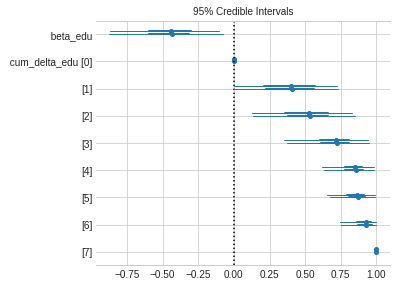

In [18]:
pm.forestplot(m_ord_cat.trace, varnames=['beta_edu', 'cum_delta_edu'], rhat=False)
None

In [23]:
with pm.Model() as m_ord_cat_all:
    n_edus = edus.shape[0]

    cutpoints = pm.Normal(
        'cutpoints', mu=0, sd=1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.linspace(-3, 3, 6),
    )
    beta_edu = pm.Normal('beta_edu', mu=0, sd=0.5)
    delta_edu = pm.Dirichlet('delta_edu', a=np.ones(n_edus-1))

    cum_delta_edu = pm.Deterministic(
        'cum_delta_edu',
        tt.as_tensor_variable(
            [pm.math.sum(delta_edu[0:(end)])
             for end in range(n_edus)]
        )
    )
    
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    beta2 = pm.Normal('beta2', mu=0, sd=0.5, shape=2)
    
    phi = pm.Deterministic(
        'phi',
        beta_edu * cum_delta_edu[data.edu_i.values]
        + beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
        + beta2[0] * (data.intention.values * data.action.values)
        + beta2[1] * (data.intention.values * data.contact.values)
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=(data.response.values - 1)
    )

    m_ord_cat_all.name = 'all'
    m_ord_cat_all.trace = pm.sample(
        3000, tune=2000, chains=2,
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta2, beta, delta_edu, beta_edu, cutpoints]
Sampling 2 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

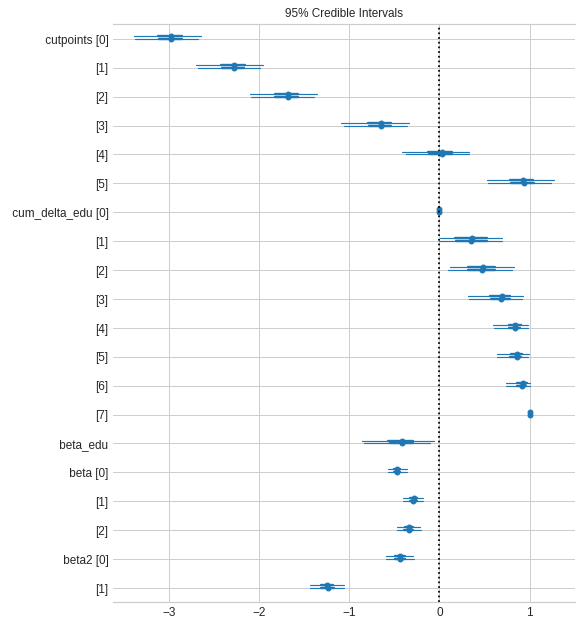

In [29]:
fig = plt.figure(figsize=(8, 8), dpi=85)
pm.forestplot(m_ord_cat_all.trace,
              varnames=['cutpoints', 'cum_delta_edu', 'beta_edu', 'beta', 'beta2'],
              rhat=False)
None

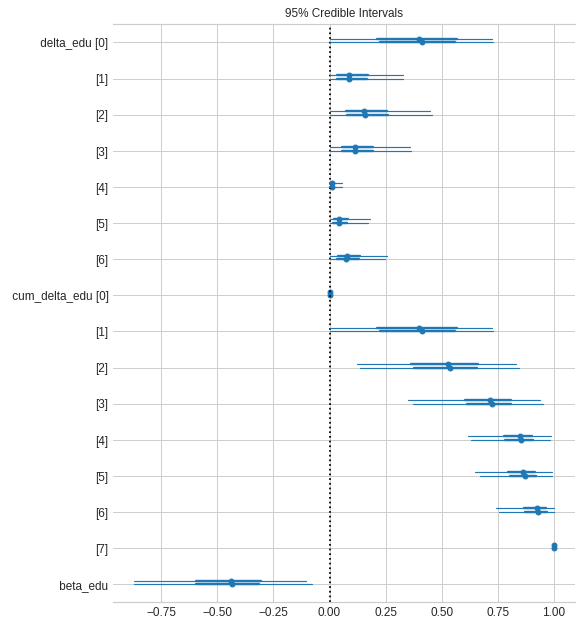

In [33]:
fig = plt.figure(figsize=(8, 8), dpi=85)
pm.forestplot(m_ord_cat.trace,
              varnames=['delta_edu', 'cum_delta_edu', 'beta_edu'],
              rhat=False)
None

In [26]:
comparison = pm.compare({
        m11_1: m11_1.trace,
        m11_2: m11_2.trace,
        m11_3: m11_3.trace,
        m_ord_cat: m_ord_cat.trace,
        m_ord_cat_all: m_ord_cat_all.trace
    },
    method='BB-pseudo-BMA'
)

comparison

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
all,36916.5,13.27,0,0.54,78.88,0,0
m11.3,36929.2,10.96,12.73,0.46,82.39,114.3,0
m11.2,37090,9.02,173.56,0,77.96,110.87,0
ordered categories,37842.4,8.02,925.97,0,57.1,61.95,0
m11.1,37854.4,5.99,937.95,0,59.18,99.57,0
